# Creating Shape Points for BEDMAP3

Author: Alice Fremand (@almand)

Date: 26/04/2022

## The BEDMAP3 project

Bedmap3 is a collaborative community project with the aim to produce a new map and datasets of Antarctic ice thickness and bed topography for the international glaciology and geophysical community, using a variety of data (including ice-thickness, bathymetry, surface altitude and grounding lines).

Additionally Bedmap3 will act as a repository and portal for standardized RES data for the glaciology and Geophysics community.

For more information about the project: https://www.scar.org/science/bedmap3/home/

## Creating shape Points

The goal of the tutorial is to show how the Shape Points have been created as an intermediary file of the BEDMAP3 project. The goal of this code is to grid averaged values of ice thickness, bed and surface elevation at the centre of each pixel of a 500x500m grid. 

### Virtual environment

For the code to run, it is important to install the correct dependancies and libraries. In particular the following libraries are crucial for the code to be run: 

* geopandas
* numpy
* Scipy
* math

**Note**: It is recommended to install geopandas first as it will upload most of the needed libraries at the same time without interoperability issues.

The list of dependancies uploaded in the current environment is given in the list below:

In [3]:
pip list

Package                       Version
----------------------------- -------------------
argon2-cffi                   21.1.0
attrs                         21.2.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
bleach                        4.1.0
certifi                       2021.5.30
cffi                          1.14.6
click                         7.1.2
click-plugins                 1.1.1
cligj                         0.7.1
cloudpickle                   1.6.0
colorama                      0.4.4
cycler                        0.10.0
decorator                     5.0.9
defusedxml                    0.7.1
entrypoints                   0.3
Fiona                         1.8.18
GDAL                          3.1.4
geopandas                     0.9.0
ipykernel                     5.5.5
ipython                       7.23.1
ipython-genutils              0.2.0
ipywidgets                    7.6.5
jedi                          0.18.0
Jinja2                        3.0.1
jso

### Upload the modules

* geopandas: used to create geodataframe and easily save the result to shapefiles or geopackages.
* ll2ps_projection: set of tools used for the conversion from latitude/longitude to stereographic coordinates.
The ll2ps projection script correspond to the projection.py script that can be downloaded from the following link:
Agosta, C. (2019, January 24). Agosta et al. (2019), The Cryosphere : data processing, analyses and figures. Zenodo. https://doi.org/10.5281/zenodo.2548848
* Other modules: numpy, gdal, pandas, os, glob, math, scipy, pathlib

In [4]:
import numpy as np
import gdal
import pandas as pd
import os
import glob
import math
from scipy.stats import iqr
import geopandas as gpd
from pathlib import Path
import warnings

from shapefile_processing.ll2ps_projection import stereosouth_lonlat2xy# for lon/lat to xy projection (see stereosouth_xy2lonlat function)

### Load initial grid
The first step of the code is to import a raster mask that is used to get the location of the points in a referenced grid. The raster mask consists of a GeoTIFF image with pixels of 500x500m in size. The code opens the file and gets relevant parameters.  From the image we get an array of x and y values that are located at the centre of each pixel.


In [5]:
# Opening reference GeoTIFF and get relevant parameters
refIm = "E:/UKPDC/Bedmap3/Peter/BEDMAP3_shapefile_processing_Input_extent500x500_crop.tif" 
ds = gdal.Open(refIm)
ar = ds.GetRasterBand(1).ReadAsArray()
gt = ds.GetGeoTransform()
res = gt[1]
xmin = gt[0]
ymax = gt[3]
xsize = ds.RasterXSize
ysize = ds.RasterYSize
ds = None
xstart = xmin + res/2 
ystart = ymax - res/2

# Create array of x and y values at the centre of each pixel
x = np.arange(xstart, xstart + xsize * res, res)
y = np.arange(ystart, ystart -ysize * res, -res )

### Create a grid of x and y size that will contain all the values for each point from the bed elevation picks

From the GeoTIFF image, we can create an empty array that will be used to contain the data in each pixel



In [6]:
values = np.empty((xsize,ysize,), dtype = np.dtype(list))

### Initiate the different variables


In [7]:
lon_point = [] #longitude points from csv file
lat_point = [] #latitude points from csv file
ice_thickness = [] #ice thickness points from csv file
surfElev = [] #surf elev points from csv file
bedElev = [] #bed elev points from csv file
index = [] #will give index for x and y where there are data in csv file

### Open the standardised CSV files

The code reads the standardised csv files using pandas. First, the values of latitude, longitude, ice thickness, bed and surface elevation are saved are extracted from the dataframe and stored in the respective following variables: 
lat_point, lon_point, ice_thickness, bedElev, surfElev.

To do that, we create a function that will read the data and return the information we need: latitude, longitude, ice thickness, bed and surface elevation. We select only the data where at least ice thickness, bed or surface elevation is  not equal to -9999. Indeed, values of -9999 was given where no values exist.

In [8]:
def read_Aerogeophysics(input_file, lon, lat, ice_thickness, surfElev, bedElev):
    "Function to read bed elevation picks data in the standardised format"
    print('file name: %s' %input_file) #print filename of file processed   
    data = pd.read_csv(input_file) #open input file 
    Lat_i= [variable for variable in data.columns.tolist() if (variable.startswith(' Latitude'))][0] #latitude WGS84 data
    Lon_i = [variable for variable in data.columns.tolist() if (variable.startswith(' Longitude'))][0] #Longitude WGS84 data
    ice_i = [variable for variable in data.columns.tolist() if (variable.startswith(' Ice'))][0] #ice thickness WGS84 data
    surf_i = [variable for variable in data.columns.tolist() if (variable.startswith(' Surface'))][0] #surf elev WGS84 data
    bed_i = [variable for variable in data.columns.tolist() if (variable.startswith(' Bed'))][0] #bed elev WGS84 data
    for i in range(1, len(data)): #To select only data with ice thickness, bed or surface elevation values
        if data[ice_i][i] > -9000 or data[surf_i][i] > -9000 or data[bed_i][i] > -9000:
            ice_thickness.append(float(data[ice_i][i]))
            surfElev.append(float(data[surf_i][i]))
            bedElev.append(float(data[bed_i][i]))
            lon.append(float(data[Lon_i][i]))
            lat.append(float(data[Lat_i][i]))
    return lat, lon, ice_thickness, surfElev, bedElev #give latitude, longitude (WGS84, decimal degree) and ice thickness from file. -9999 values are excluded


Then, we give the location of the file and use the function to load the data to the initiated variables:

In [9]:
aerogeophysics_data = 'E:/UKPDC/Bedmap3/AWI/standardisedCSV/AWI_2014_GEA-IV_AIR_BM3.csv'
ID = aerogeophysics_data.split('/')[-1].strip('.csv')
ID_split = ID.split('_')
lat_point, lon_point, ice_thickness, surfElev, bedElev  = read_Aerogeophysics(aerogeophysics_data, lon_point, lat_point, ice_thickness, surfElev, bedElev) #To comment if calculating at the data provider level

file name: E:/UKPDC/Bedmap3/AWI/standardisedCSV/AWI_2014_GEA-IV_AIR_BM3.csv


### Convert the latitude and longitude to polar stereographic coordinates

We used the `stereosouth_lonlat2xy` to convert the data to polar stereographic coordinates

In [10]:
lonpolar, latpolar = stereosouth_lonlat2xy(lon_point, lat_point)
lonpolar, latpolar = lonpolar*1000, latpolar*1000 #To convert in meters

### Calculate the index

The goal then is to determine the index of the latitude and longitude of each data row so the data can be added to the pixel corresponding to the location of the data.
In other words, for each latitude and longitude couple, we determine in which pixel the values of ice thickness, bed and surface elevation should be assign to. We will also calculate the distance between the latitude, longitude from csv file to x,y from the reference image to know how far from the center of the pixel the data is.

**Note**: The size of the pixel is of 500 meters


In [11]:
def Distance(x1, y1, x2, y2):
    "To calculate the distance between 2 points"
    dist = math.sqrt((x1-x2)*(x1-x2) + (y1-y2)*(y1-y2))
    return dist 

for j in range(0, len(lat_point)):
    indlat = int(round(abs(latpolar[j] - y[0])/500)) #To get latitude index
    indlon = int(round(abs(lonpolar[j] - x[0])/500)) #To get longitude index
    dist = Distance(x[indlon], y[indlat], lonpolar[j], latpolar[j]) #Calculate the distance between the latitude, longitude from csv file to x,y from the reference image
    if values[indlon][indlat] == None: #When this is the first point to be added to the variable values
        values[indlon][indlat] = [[x[indlon], y[indlat], lonpolar[j], latpolar[j], lon_point[j], lat_point[j], ice_thickness[j], surfElev[j], bedElev[j], dist]]
        index.append([indlon, indlat])
    else:
        values[indlon][indlat].append([x[indlon], y[indlat], lonpolar[j], latpolar[j], lon_point[j], lat_point[j], ice_thickness[j], surfElev[j], bedElev[j], dist])


### Calculate statistics for each pixel values

Then, we calculate the mean, iqr, min, max values of each variables in each pixel. This calculation is only done when there are values in a pixel. Values of -9999 are given when the information is missing. Values are rounded to the closest integer.

In [12]:
point_values = []
for k in range(0, len(index)):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        df_temp = pd.DataFrame(values[index[k][0]][index[k][1]])
        df_temp_nan = df_temp.replace(-9999.0, np.nan)
        mean_dist = round(df_temp_nan[9].mean()) # mean distance to the point
        df_points = len(df_temp)
        
        #Ice thickness statistics
        mean_thick = -9999 if math.isnan(df_temp_nan[6].mean()) else round(df_temp_nan[6].mean()) #mean of ice thickness
        median_thick = -9999 if math.isnan(df_temp_nan[6].median()) else round(df_temp_nan[6].median()) #median for ice thickness        
        iqr_thick = -9999 if math.isnan(iqr(df_temp[6][df_temp[6] != -9999.])) else round(iqr(df_temp[6][df_temp[6] != -9999.])) # IQR range for value of ice thickness at the specific point
        min_thick = -9999 if math.isnan(df_temp_nan[6].min()) else round(df_temp_nan[6].min()) #minimum value of ice thickness at the specific point
        max_thick = -9999 if math.isnan(df_temp_nan[6].max()) else round(df_temp_nan[6].max()) #maximum value of ice thickness at the specific point
        nb_point_thick = df_points - df_temp[6][df_temp[6] == -9999.].shape[0] #to calculate the number of points used to calculate the ice thickness at the specific point 
        if len(values[index[k][0]][index[k][1]])==1 or math.isnan(df_temp_nan[6].std()):
            std_thick = -9999
            SE_thick = -9999
        else:
            std_thick = round(df_temp_nan[6].std()) #standard deviation if ice thickness values at the specific point
            SE_thick = std_thick/np.sqrt(nb_point_thick)
            
        #Bed elevation statistics
        mean_bed = -9999 if math.isnan(df_temp_nan[8].mean()) else round(df_temp_nan[8].mean()) #mean of ice thickness
        median_bed = -9999 if math.isnan(df_temp_nan[8].median()) else round(df_temp_nan[8].median()) #median for ice thickness
        iqr_bed = -9999 if math.isnan(iqr(df_temp[8][df_temp[8] != -9999.])) else round(iqr(df_temp[8][df_temp[8] != -9999.])) # IQR range for value of ice thickness at the specific point
        min_bed = -9999 if math.isnan(df_temp_nan[8].min()) else round(df_temp_nan[8].min()) #minimum value of ice thickness at the specific point
        max_bed = -9999 if math.isnan(df_temp_nan[8].max()) else round(df_temp_nan[8].max()) #maximum value of ice thickness at the specific point
        nb_point_bed = df_points - df_temp[8][df_temp[8] == -9999.].shape[0] #to calculate the number of points used to calculate the ice thickness at the specific point 
        if len(values[index[k][0]][index[k][1]])==1 or math.isnan(df_temp_nan[8].std()):
            std_bed = -9999
            SE_bed = -9999
        else:
            std_bed = round(df_temp_nan[8].std()) #standard deviation if ice thickness values at the specific point
            SE_bed = std_bed/np.sqrt(nb_point_bed)
            
        #Surface elevation statistics
        mean_surf = -9999 if math.isnan(df_temp_nan[7].mean()) else round(df_temp_nan[7].mean()) #mean of ice thickness
        median_surf = -9999 if math.isnan(df_temp_nan[7].median()) else round(df_temp_nan[7].median()) #median for ice thickness
        iqr_surf = -9999 if math.isnan(iqr(df_temp[7][df_temp[7] != -9999.])) else round(iqr(df_temp[7][df_temp[7] != -9999.])) # IQR range for value of ice thickness at the specific point
        min_surf = -9999 if math.isnan(df_temp_nan[7].min()) else round(df_temp_nan[7].min()) #minimum value of ice thickness at the specific point
        max_surf = -9999 if math.isnan(df_temp_nan[7].max()) else round(df_temp_nan[7].max()) #maximum value of ice thickness at the specific point
        nb_point_surf = df_points - df_temp[7][df_temp[7] == -9999.].shape[0] #to calculate the number of points used to calculate the ice thickness at the specific point 
        std_surf = df_temp_nan[7].std()
        if len(values[index[k][0]][index[k][1]])==1 or math.isnan(df_temp_nan[7].std()):
            std_surf = -9999
            SE_surf = -9999
        else:
            std_surf = round(df_temp_nan[7].std()) #standard deviation if ice thickness values at the specific point
            SE_surf = std_surf/np.sqrt(nb_point_surf)
            
        point_values.append([float(x[index[k][0]]), float(y[index[k][1]]), 
                             mean_thick, median_thick, std_thick, nb_point_thick, iqr_thick, SE_thick, min_thick, max_thick,
                             mean_surf, median_surf, std_surf, nb_point_surf, iqr_surf, SE_surf, min_surf, max_surf,
                             mean_bed, median_bed, std_bed, nb_point_bed, iqr_bed, SE_bed, min_bed, max_bed, mean_dist])


### Saving the data as a geo-dataframe

The values are saved into a dataframe and then converted into a geodataframe. The data are then saved as shapefiles and geopackages. To make sure the files are not too big, we set the columns as integer. 

#### Creation of the columns

First, we convert the point values to a dataframe:

In [38]:
columns = ['Lon', 'Lat',
           'Mean_thick_m', 'Med_thick_m', 'SD_thick', 'Count_thick', 'IQR_thick', 'STE_thick', 'Min_thick_m', 'Max_thick_m', 
           'Mean_surf_m', 'Median_surf_m', 'SD_surf', 'Count_surf', 'IQR_surf', 'STE_surf', 'Min_surf_m', 'Max_surf_m', 
           'Mean_bed_m', 'Median_bed_m', 'SD_bed', 'Count_bed', 'IQR_bed', 'STE_bed', 'Min_bed_m', 'Max_bed_m', 'Mean_dist_m']
df = pd.DataFrame(point_values, columns = columns, dtype='int16') #dataframe containing all the values
df.head()

,Lon,Lat,Mean_thick_m,Med_thick_m,SD_thick,Count_thick,IQR_thick,STE_thick,Min_thick_m,Max_thick_m,...,Max_surf_m,Mean_bed_m,Median_bed_m,SD_bed,Count_bed,IQR_bed,STE_bed,Min_bed_m,Max_bed_m,Mean_dist_m
0,847750.0,1644750.0,1450,1447,35,4,40,17.500000,1412,1494,...,-9999,-9999,-9999,-9999,0,-9999,-9999,-9999,-9999,248
1,847750.0,1644250.0,1531,1531,6,2,4,4.242641,1527,1535,...,-9999,-9999,-9999,-9999,0,-9999,-9999,-9999,-9999,135
2,847750.0,1643750.0,1567,1567,14,2,10,9.899495,1556,1577,...,-9999,-9999,-9999,-9999,0,-9999,-9999,-9999,-9999,181
3,847750.0,1643250.0,1608,1608,-9999,1,0,-9999.000000,1608,1608,...,-9999,-9999,-9999,-9999,0,-9999,-9999,-9999,-9999,135
4,847750.0,1642750.0,1646,1646,-9999,1,0,-9999.000000,1646,1646,...,-9999,-9999,-9999,-9999,0,-9999,-9999,-9999,-9999,249


#### Creation of the geodataframe

Using the `geopandas` module, we can convert the dataframe to a geodataframe. To do that, we only need to specify the latitude and longitude columns of the dataframe. Then we need to specify the coordinate system used:

In [39]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Lon, df.Lat), dtype='int16') #Transformation of the dataframe to a geodataframe
gdf = gdf.drop(columns=['Lon', 'Lat']) #To not have Lat and Lon in the attributes of the shapefile/geopackage
gdf = gdf.set_crs("EPSG:3031") #Set the coordinate system
gdf.head()

,Mean_thick_m,Med_thick_m,SD_thick,Count_thick,IQR_thick,STE_thick,Min_thick_m,Max_thick_m,Mean_surf_m,Median_surf_m,...,Mean_bed_m,Median_bed_m,SD_bed,Count_bed,IQR_bed,STE_bed,Min_bed_m,Max_bed_m,Mean_dist_m,geometry
0,1450,1447,35,4,40,17,1412,1494,-9999,-9999,...,-9999,-9999,-9999,0,-9999,-9999,-9999,-9999,248,POINT (847750.000 1644750.000)
1,1531,1531,6,2,4,4,1527,1535,-9999,-9999,...,-9999,-9999,-9999,0,-9999,-9999,-9999,-9999,135,POINT (847750.000 1644250.000)
2,1567,1567,14,2,10,9,1556,1577,-9999,-9999,...,-9999,-9999,-9999,0,-9999,-9999,-9999,-9999,181,POINT (847750.000 1643750.000)
3,1608,1608,-9999,1,0,-9999,1608,1608,-9999,-9999,...,-9999,-9999,-9999,0,-9999,-9999,-9999,-9999,135,POINT (847750.000 1643250.000)
4,1646,1646,-9999,1,0,-9999,1646,1646,-9999,-9999,...,-9999,-9999,-9999,0,-9999,-9999,-9999,-9999,249,POINT (847750.000 1642750.000)


#### Save the data as shapefile and geopackages

We can then save the result to shapefile and geopackages. We made sure to use intenger for the statistics so the files are not to big and easy to handle in your favorite software:

In [15]:
variables_int = gdf.columns.tolist()
variables_int.remove('geometry')
schema = gpd.io.file.infer_schema(gdf)
for k in range(0, len(variables_int)):
    schema['properties'][variables_int[k]] = 'int32'

print('creation of files')
gdf.to_file('shapefile_processing/output/%s_points.gpkg' %ID, layer='Point_%s' %ID.replace('-', ''), driver="GPKG",  schema=schema) #To save as geopackage
#gdf.to_file('shapefile_processing/output/%s_points.shp' %ID, driver="ESRI Shapefile",  schema=schema) #To save as a shapefile


creation of files


## Results
### Plotting ice thickness

In [16]:
# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure. More about that later. 
# If you are using an old version of IPython, try using '%pylab inline' instead.
%matplotlib inline

In [17]:
import matplotlib
import matplotlib.pyplot as plt

<AxesSubplot:>

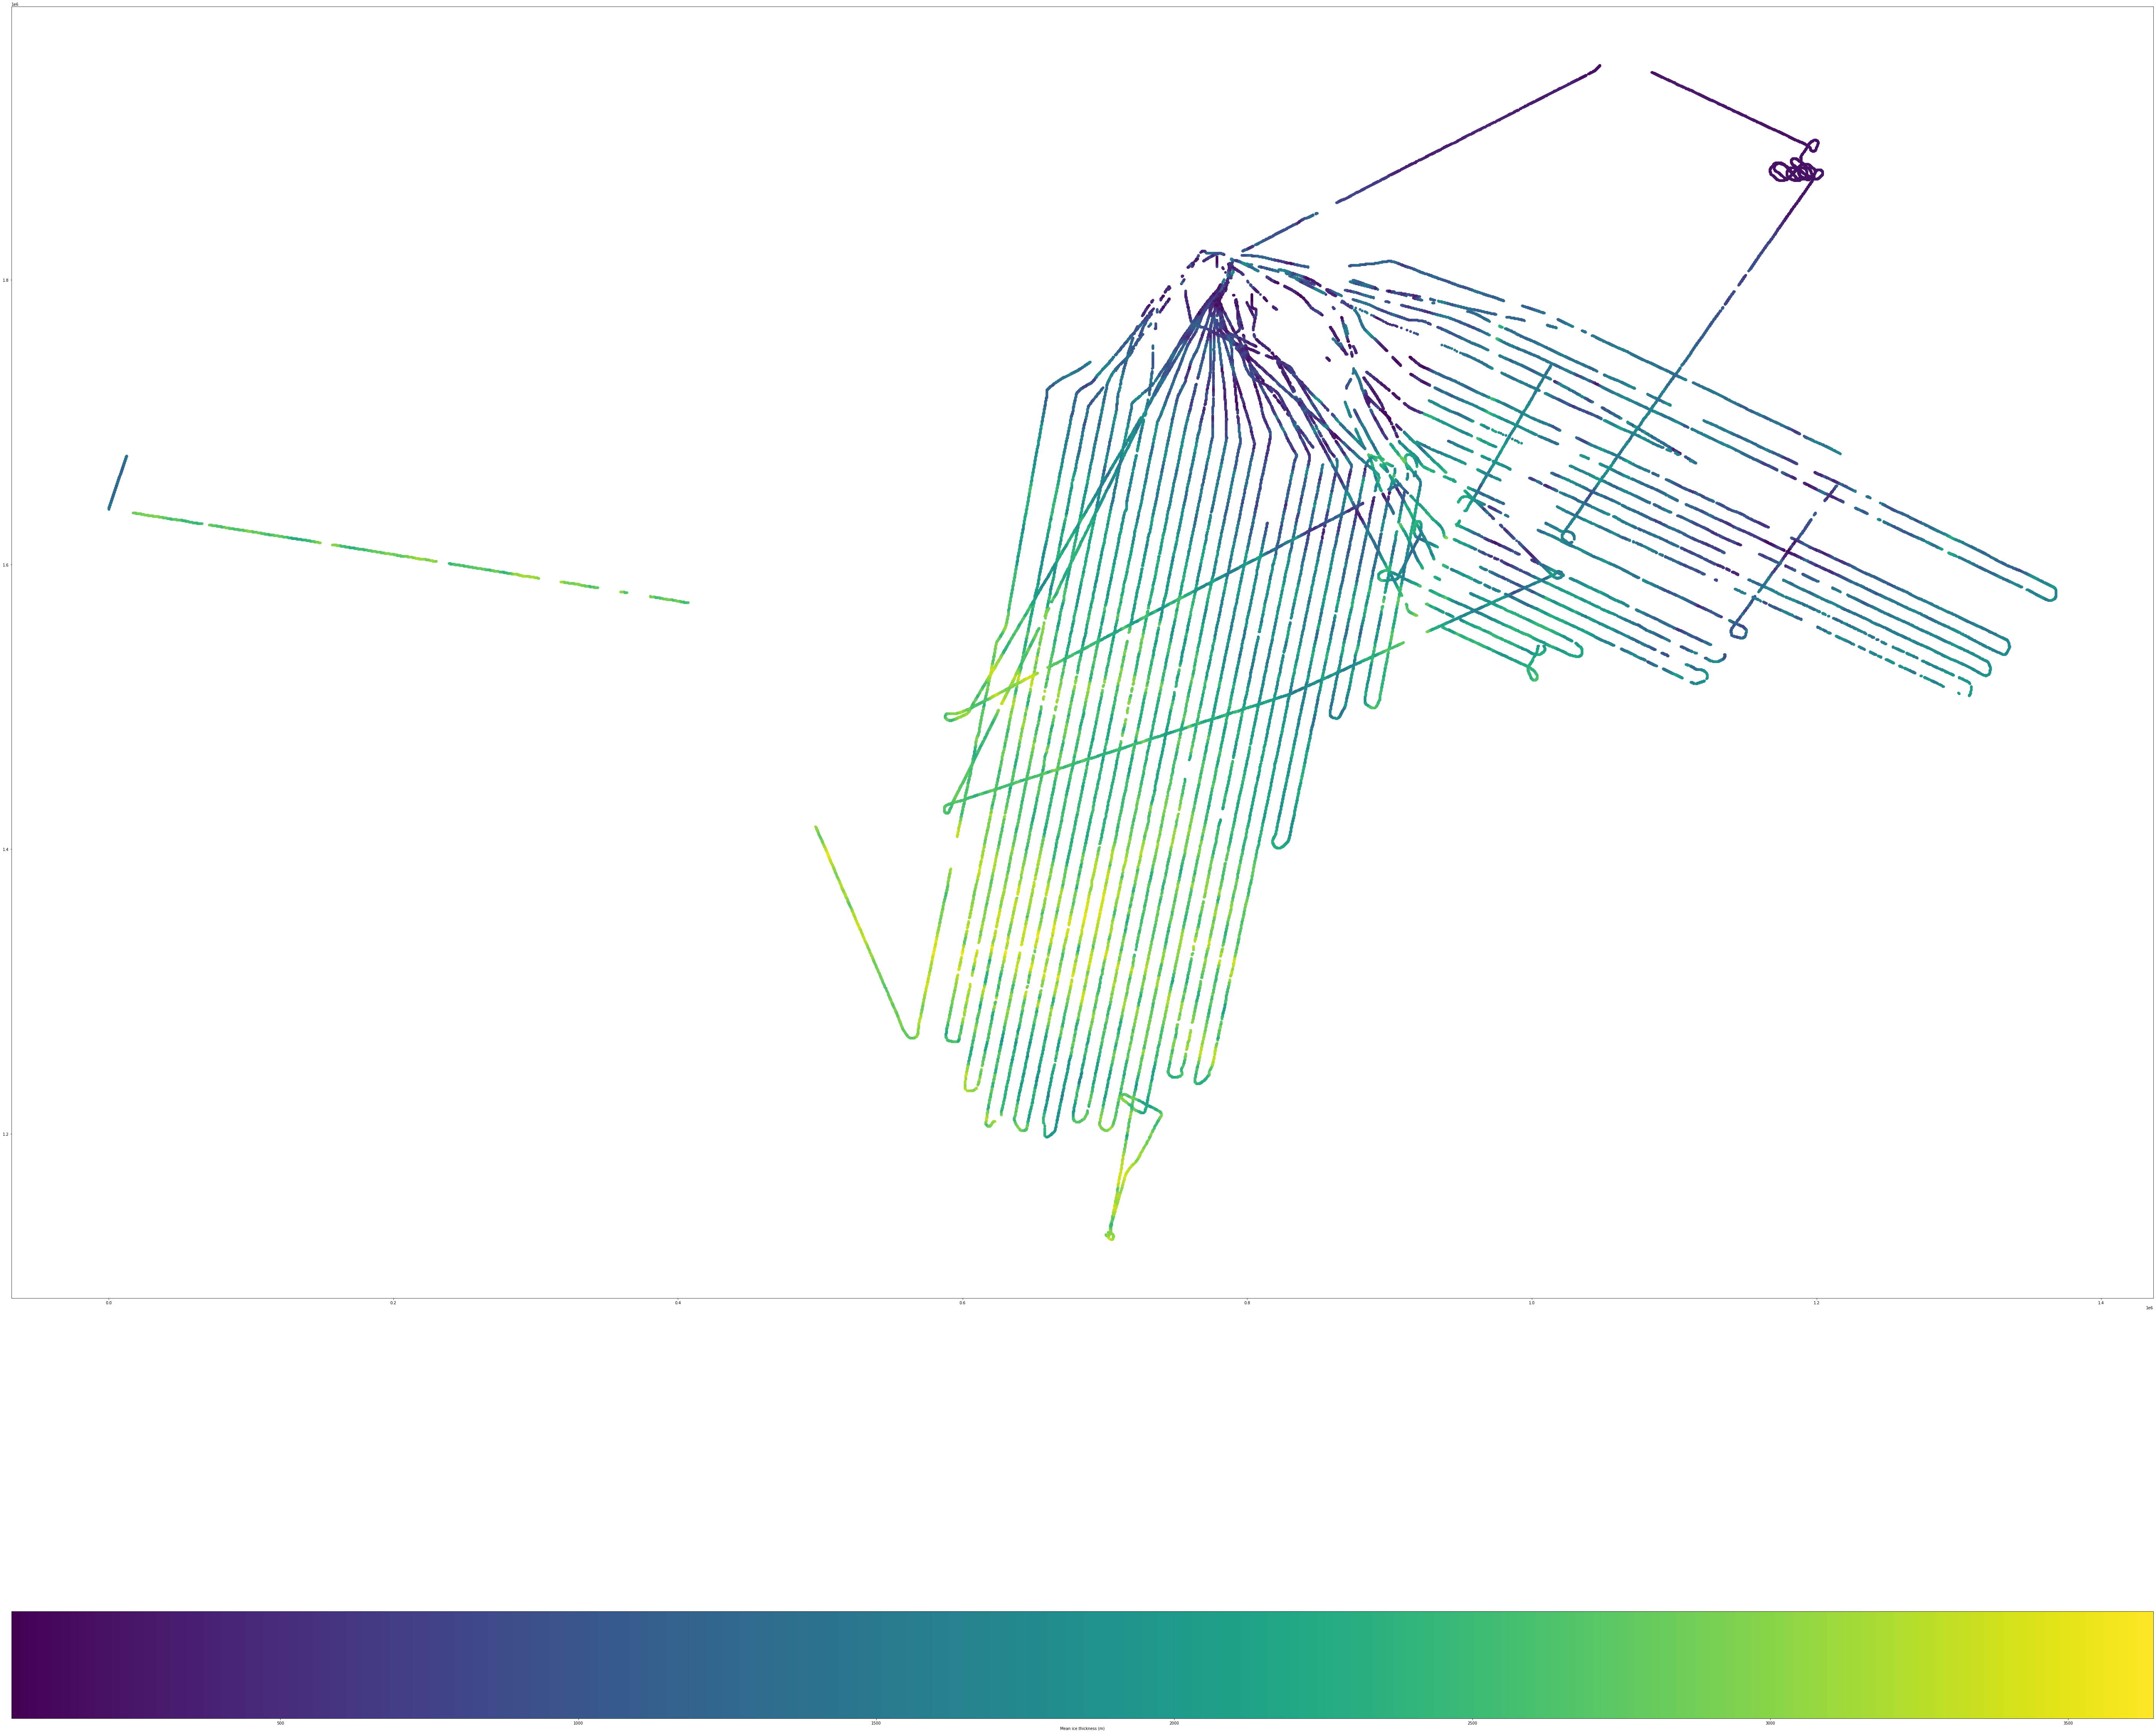

<Figure size 2000x2000 with 0 Axes>

In [37]:
fig, ax = plt.subplots(1, 1)
fig=plt.figure(figsize=(20,20), dpi= 100, facecolor='w', edgecolor='k')
gdf.plot(column='Mean_thick_m', ax=ax, legend=True, legend_kwds={'label': "Mean ice thickness (m)",'orientation': "horizontal"})

### Results

All the BEDMAP point shapefiles are available online: 

* BEDMAP1 shapePoints: 
* BEDMAP2 shapePoints:
* BEDMAP3 shapePoints: